Student Name: Tom Keane

Student ID: 20214537

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
import random
import math
from sklearn.model_selection import train_test_split
from copy import copy

### Task 3

In [97]:
# X, y = make_circles(n_samples=1000, noise = 0.05)
# y = [yy if yy == 1 else -1 for yy in y] 

<hr style="border:2px solid gray"> </hr>

In [98]:
from sklearn.datasets import make_circles

def circles_setup(n_samples=1000, noise=0.05, plot=True):
    X, y = make_circles(n_samples=1000, noise=0.05)
    y = [yy if yy == 1 else -1 for yy in y]
    if plot == True:
        plot_data_set(X, y)
    return X, y

def plot_data_set(X, y, axis=None):
    if axis is None:
        plt.scatter(X[:,0], X[:,1], c=y)
        plt.title("circles")
        plt.xlabel('$x_a$')
        plt.ylabel('$x_b$')
    else:
        axis.scatter(X[:,0], X[:,1], c=y)
        axis.set_xlabel('$x_a$')
        axis.set_ylabel('$x_b$')

make_circles can be used to create datasets with concentric classes. These are popular types of datasets to test input data transformations.

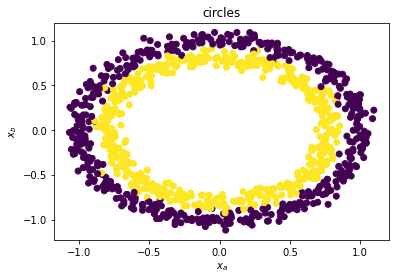

In [99]:
X, y = circles_setup()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [100]:
#HELPER FUNCTIONS
def randomWeight():
    w = np.random.uniform(-0.5, 0.5)
    w = w + 0.1 if w > 0 else w - 0.1
    return w

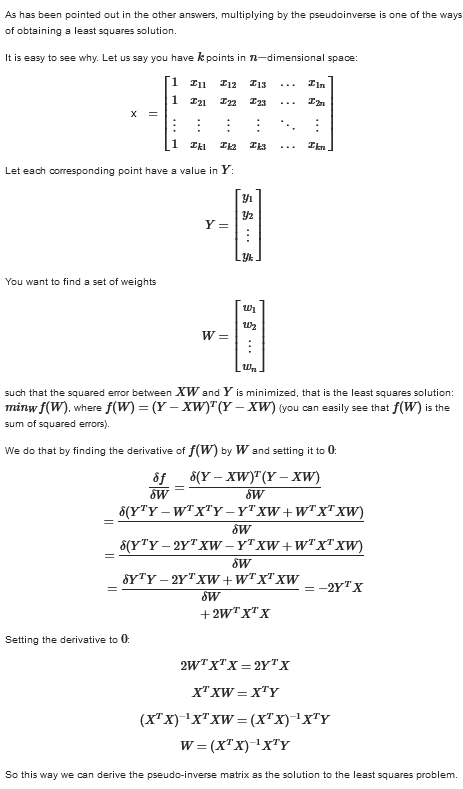

In [101]:
from IPython.display import Image
Image(filename='leastSqr_pseudo_inverse_method.png')

And $X^{+} = (X^{T}X)^{-1}X^{T}$
which for a matrix of liearly independant columns is the Moore-Penrose-inverse

https://stats.stackexchange.com/questions/266631what-is-the-difference-between-least-square-and-pseudo-inverse-techniques-for-li

My linear classifier invokes the pseudo-inverse mehtod to fit the weights, using a matrix of inputs X and their classifications y.
X is then converted to X1, by adding a column of biases (1) to the beginning of the data-points. This is then used to find the coefficients (weights) of this fields least squares error, by dotting X1's pseudo-inverse onto the data points Y.

In [102]:
class LinearClassifier:
    def __init__(self, weights=None, bias=1):
        self.Bias = bias
        self.Weights = weights
        
    def sign_fn(self, w, X):
        X1 = self.prepare_X_for_pseudo_inv_method(X)
        return np.sign( np.dot(X1, w))

    def prepare_X_for_pseudo_inv_method(self, X):
        return np.c_[np.full(len(X), self.Bias), X]

    def fit(self, X, y):
        self.X = X
        self.y = y
        X1 = self.prepare_X_for_pseudo_inv_method(X)
        X1_pseudInv = np.linalg.pinv(X1)
        self.Weights = np.dot(X1_pseudInv, y)

    def predict(self, X):
        return self.sign_fn(self.Weights, X)

    def score(self, X=None, y=None, plot=False, axis=None):
        X = self.X if X is None else X
        y = self.y if y is None else y
        y_pred = self.predict(X)
        if plot:
            self.plot_predictions(X, y_pred, axis=axis)
        return np.sum(y_pred == y)/ len(y)
    
    def plot_predictions(self, X, y, axis=None):
        # print(f"features shape   {X.shape}")
        plot_data_set(X, y, axis=axis)

In [103]:
model = LinearClassifier()

0.432


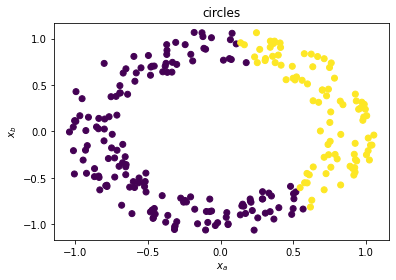

In [104]:
model.fit(X_train, y_train)
print(model.score(X_test, y_test, True))

clearly the model doesn't perform well with the original data-set. There isn't enough information provided here for it to be able to separate the two classes.

In [105]:
def add_quadratic_features(X):
    xy, x2, y2  = X[:,1]*X[:,0], X[:,0]**2, X[:,1]**2
    return np.c_[X, xy, x2, y2]

def add_cubic_features(X):
    x2y, y2x, x3, y3 = (X[:,1]**2)*X[:,0], X[:,1]*(X[:,0]**2), X[:,0]**3, X[:,1]**3
    return np.c_[X, x2y, y2x, x3, y3]

def add_nthOrder_features(X, n):
    comps = np.empty([len(X),0])
    for i in range(n+1):
        comps = np.c_[comps, (X[:,0]**(n-i))*X[:,1]**i]
    return np.c_[X, comps]

def add_radial_feature(X):
    r = (X[:,0]**2 + X[:,1]**2)**.5
    return np.c_[X, r]

Here are some tests to verify that add_nthOrder_features is working as expected.

0.972
0.972


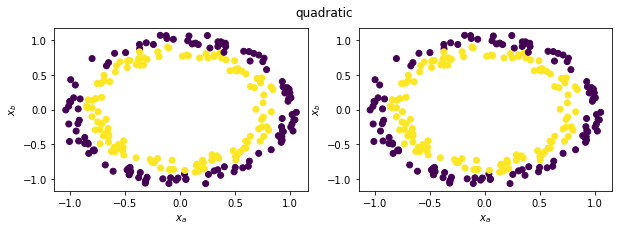

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))
fig.suptitle(f"quadratic")
model.fit(add_quadratic_features(X_train), y_train)
print(model.score(add_quadratic_features(X_test), y_test, plot=True, axis=axes[0]))

model.fit(add_nthOrder_features(X_train, 2), y_train)
print(model.score(add_nthOrder_features(X_test, 2), y_test, plot=True, axis=axes[1]))

score  0.508
score  0.508


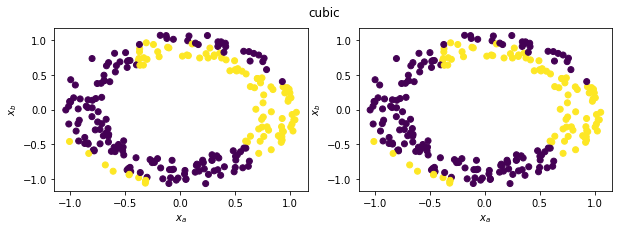

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))
fig.suptitle(f"cubic")
model.fit(add_cubic_features(X_train), y_train)
print(f"score  {model.score(add_cubic_features(X_test), y_test, plot=True, axis=axes[0])}")

model.fit(add_nthOrder_features(X_train, 3), y_train)
print(f"score  {model.score(add_nthOrder_features(X_test, 3), y_test, plot=True, axis=axes[1])}")

In [108]:
def runModel(model, X_train, y_train, X_test, y_test):
    fig, axes = plt.subplots(2, 3, figsize=(20,10))
    fig.suptitle(type(model).__name__)
    for i, axis in zip(np.arange(1,7), axes.flatten()):
        m=copy(model)
        m.fit(add_nthOrder_features(X_train, i), y_train)
        X_n = add_nthOrder_features(X_test, i)
        s = round(m.score(X_n, y_test), 4)
        plot_data_set(X_n, m.predict(X_n), axis=axis)
        axis.set_title(f"x ... x^{i} order features\nscore {s}")

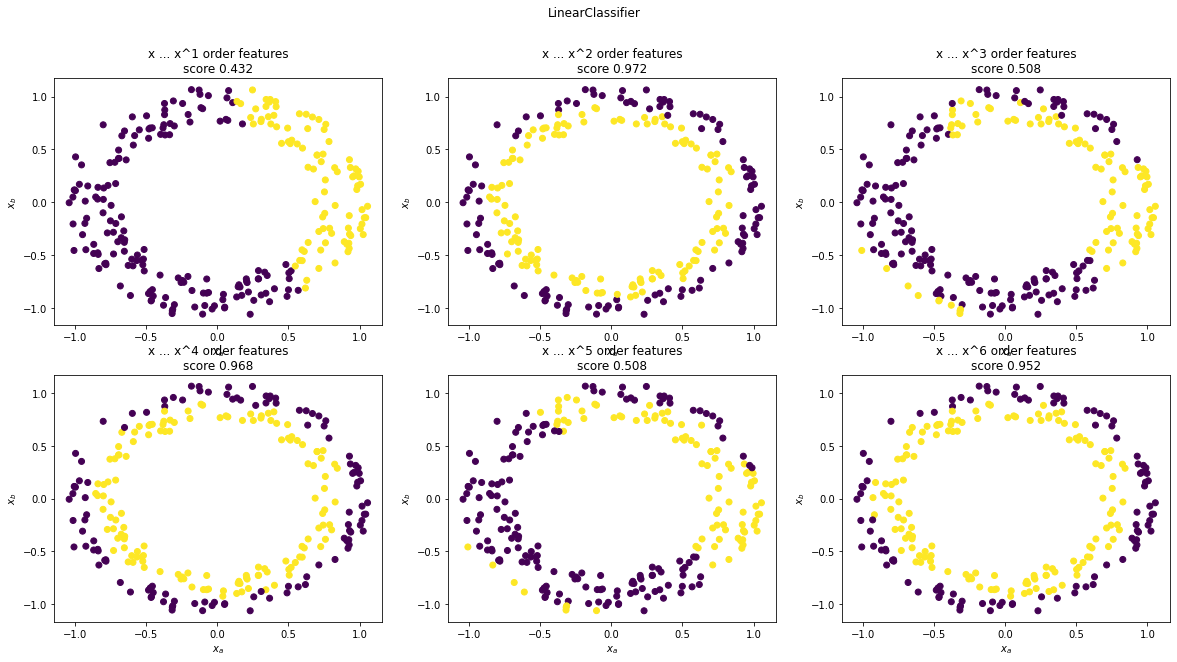

In [109]:
runModel(model, X_train, y_train, X_test, y_test)

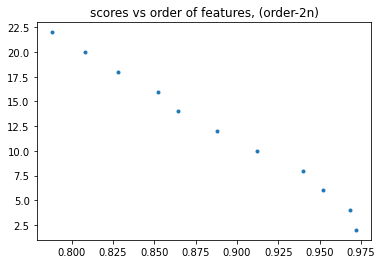

In [110]:
scores = []
score_range = [i for i in range(2, 23, 2)]
for i in score_range:
    model.fit(add_nthOrder_features(X_train, i), y_train)
    s = model.score(add_nthOrder_features(X_test, i), y_test)
    scores.append(s)
plt.plot(scores, score_range, '.')
plt.title("scores vs order of features, (order-2n)")
plt.show()

evens look accurate, but more noise causes interference as the orders go up, drowning out the 
$x^{2n}$ or $y^{2n}$ values, which as multiples of $x^2$ or $y^2$ would store useful information.

## Speculation
The drop in performance as the order of features rise could be due to a drop in ratio between liearly independent and non-linearly indepndent features at higher orders of components.

For exammple if the order rises (to say n=6), there will be useful features such as $x^6$ and $y^6$, but there are also more features such as $x^5y$ and $y^5x$ which will create noise, reducing the classifiers effectiveness.

I'll try a radial feature

score   0.968


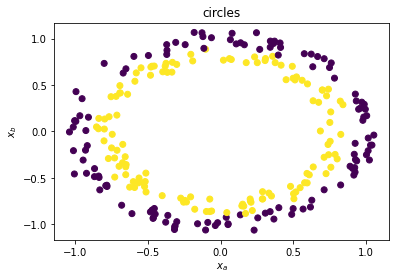

In [111]:
model.fit(add_radial_feature(X_train), y_train)
print(f"score   {model.score(add_radial_feature(X_test), y_test, plot=True)}")

The radial feature is about as effective as the addition of a quadratic feature.

Now let's compare my linear classifier's performance with scikitlearns LogistoRegressor

In [112]:
Log_reg = LogisticRegression()

LinearClassifier


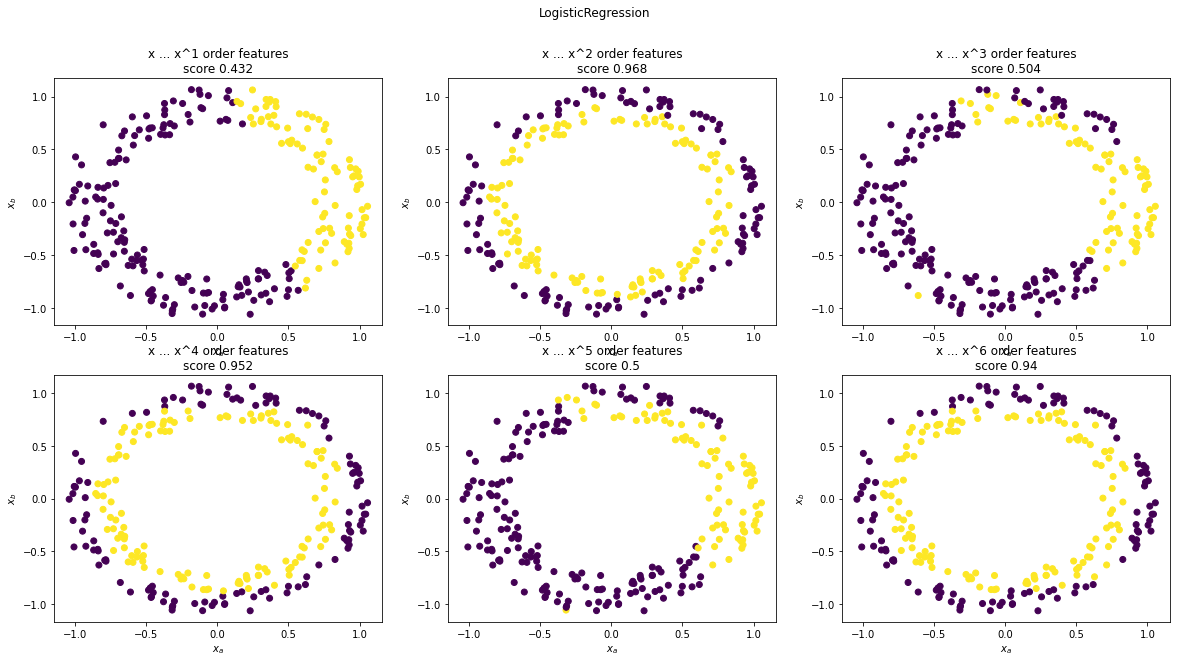

In [113]:
print(type(model).__name__)
runModel(Log_reg, X_train, y_train, X_test, y_test)

similarly, to my own linear classifier, the logistic regressor performs well with even numbered order features.

and finally investigate how the logisic regressor performs with the addition of a radial feature. 

score   0.968
radial feature


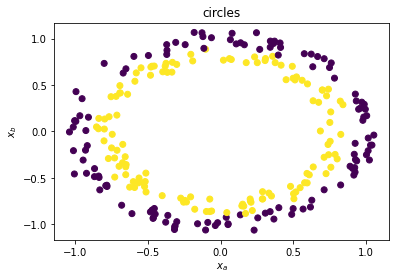

In [114]:
Log_reg.fit(add_radial_feature(X_train), y_train)
print(f"score   {Log_reg.score(add_radial_feature(X_test), y_test)}")
print("radial feature")
X_n = add_radial_feature(X_test)
plot_data_set(X_n, Log_reg.predict(X_n))


Again, the logistic regressor performs about as well as my custom linear classifier.

By default the sklearn [logistic regressor](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) uses Limited-memory BFGS (L-BFGS or LM-BFGS).
This is essentially another method to minimise the the model's cost.

Therefore it should be no surprised that given the same **good** features, it performs similarly to the custom Linear classifier.


The model is performing well, the two models tend to converge at the same values. This could be due to the fact that they're both **linear** classification models. This means that the models can be tricked by the outlying noise created in the make_moons data-set.